<a href="https://colab.research.google.com/github/Elifyildizz/Sentiment-Analysis-on-IMDb-Movie-Reviews/blob/main/NLP_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Configuration


In [ ]:
import pandas as pd
import numpy as np
import time
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import warnings
warnings.filterwarnings("ignore")

# Load Dataset from KaggleHub

In [ ]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path = os.path.join(path, "IMDB Dataset.csv")
data = pd.read_csv(csv_path)

In [ ]:
display(data.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
display(data.tail())

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [ ]:
data.shape

(50000, 2)

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


# Label Encoding for Sentiment Classes

In [ ]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0
49999,No one expects the Star Trek movies to be high...,0


# Prepare Data

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["review"].tolist(), data["sentiment"].tolist(), test_size=0.2, random_state=42
)

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Data Preprocessing (Tokenization)

In [ ]:
# Common preprocessing function
def preprocess_data(tokenizer):
    def tokenize_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

    train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
    val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
    test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    return tokenized_train,tokenized_val, tokenized_test

# Metrics Computation Function

In [ ]:
# Shared compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Train Each Model Separately and Collect Results
### Model 1: nikolasmoya/imdb-binary-sentiment-analysis

In [ ]:
results = list()

# Train imdb model
start_imdb = time.time()
nikolasmoya_model_name = "nikolasmoya/imdb-binary-sentiment-analysis"
nikolasmoya_tokenizer = AutoTokenizer.from_pretrained(nikolasmoya_model_name)
nikolasmoya_model = AutoModelForSequenceClassification.from_pretrained(nikolasmoya_model_name)

nikolasmoya_tokenized_train, nikolasmoya_tokenized_eval, nikolasmoya_tokenized_test = preprocess_data(nikolasmoya_tokenizer)
nikolasmoya_data_collator = DataCollatorWithPadding(tokenizer=nikolasmoya_tokenizer)

nikolasmoya_training_args = TrainingArguments(
output_dir="./results/imdb",
learning_rate=2e-5,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=2,
weight_decay=0.01,
logging_dir='./logs'
)

nikolasmoya_trainer = Trainer(
    model=nikolasmoya_model,
    args=nikolasmoya_training_args,
    train_dataset=nikolasmoya_tokenized_train,
    eval_dataset=nikolasmoya_tokenized_eval,
    tokenizer=nikolasmoya_tokenizer,
    data_collator=nikolasmoya_data_collator,
    compute_metrics=compute_metrics
)

nikolasmoya_trainer.train()
nikolasmoya_results = nikolasmoya_trainer.evaluate()
print("IMDB Model Results:")
print(nikolasmoya_results)
nikolasmoya_preds = np.argmax(nikolasmoya_trainer.predict(nikolasmoya_tokenized_test).predictions, axis=-1)
print(classification_report(test_labels, nikolasmoya_preds, target_names=["Negative", "Positive"]))
end_imdb = time.time()
nikolasmoya_results["model"] = "nikolasmoya/imdb-binary-sentiment-analysis"
nikolasmoya_results["time_sec"] = end_imdb - start_imdb
results.append(nikolasmoya_results)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: elifyildiz6774 (elifestrella-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.176200
1000,0.183000
1500,0.175600
2000,0.158800
2500,0.091000
3000,0.103000
3500,0.091500
4000,0.090400


IMDB Model Results:
{'eval_loss': 0.184051513671875, 'eval_accuracy': 0.95575, 'eval_precision': 0.9630746043707611, 'eval_recall': 0.9487750556792873, 'eval_f1': 0.955871353777113, 'eval_runtime': 29.6813, 'eval_samples_per_second': 269.53, 'eval_steps_per_second': 16.846, 'epoch': 2.0}
              precision    recall  f1-score   support

    Negative       0.96      0.95      0.95      4961
    Positive       0.95      0.96      0.96      5039

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### Model 2: kubi565/roberta-binary-sentiment-multilingual

In [ ]:
# Train roberta model
start_roberta = time.time()
roberta_model_name = "kubi565/roberta-binary-sentiment-multilingual"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

roberta_tokenized_train, roberta_tokenized_eval ,roberta_tokenized_test = preprocess_data(roberta_tokenizer)
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

roberta_training_args = TrainingArguments(
output_dir="./results/roberta",
learning_rate=2e-5,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=2,
weight_decay=0.01,
logging_dir='./logs'
)

roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_tokenized_train,
    eval_dataset=roberta_tokenized_eval,
    tokenizer=roberta_tokenizer,
    data_collator=roberta_data_collator,
    compute_metrics=compute_metrics
)

roberta_trainer.train()
roberta_results = roberta_trainer.evaluate()
print("roberta Results:")
print(roberta_results)
roberta_preds = np.argmax(roberta_trainer.predict(roberta_tokenized_test).predictions, axis=-1)
print(classification_report(test_labels, roberta_preds, target_names=["Negative", "Positive"]))
end_roberta = time.time()
roberta_results["model"] = "roberta-binary-sentiment-multilingual"
roberta_results["time_sec"] = end_roberta - start_roberta
results.append(roberta_results)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss
500,0.237800
1000,0.230000
1500,0.215200
2000,0.197600
2500,0.133300
3000,0.152200
3500,0.133100
4000,0.132100


roberta Results:
{'eval_loss': 0.25423580408096313, 'eval_accuracy': 0.938875, 'eval_precision': 0.9391691394658753, 'eval_recall': 0.9398663697104677, 'eval_f1': 0.939517625231911, 'eval_runtime': 53.7905, 'eval_samples_per_second': 148.725, 'eval_steps_per_second': 9.295, 'epoch': 2.0}
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94      4961
    Positive       0.94      0.95      0.94      5039

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Model 3: autoevaluate/binary-classification

In [ ]:
# Train binary_classification model
start_binary_classification = time.time()
binary_classification_model_name = "autoevaluate/binary-classification"
binary_classification_tokenizer = AutoTokenizer.from_pretrained(binary_classification_model_name)
binary_classification_model = AutoModelForSequenceClassification.from_pretrained(binary_classification_model_name)

binary_classification_tokenized_train,binary_classification_tokenized_eval, binary_classification_tokenized_test = preprocess_data(binary_classification_tokenizer)
binary_classification_data_collator = DataCollatorWithPadding(tokenizer=binary_classification_tokenizer)

binary_classification_training_args = TrainingArguments(
output_dir="./results/binary-classification",
learning_rate=2e-5,
per_device_train_batch_size=16,
per_device_eval_batch_size=16,
num_train_epochs=2,
weight_decay=0.01,
logging_dir='./logs'
)

binary_classification_trainer = Trainer(
    model=binary_classification_model,
    args=binary_classification_training_args,
    train_dataset=binary_classification_tokenized_train,
    eval_dataset=binary_classification_tokenized_eval,
    tokenizer=binary_classification_tokenizer,
    data_collator=binary_classification_data_collator,
    compute_metrics=compute_metrics
)

binary_classification_trainer.train()
binary_classification_results = binary_classification_trainer.evaluate()
print("Binary Classification Results:")
print(binary_classification_results)
binary_classification_preds = np.argmax(binary_classification_trainer.predict(binary_classification_tokenized_test).predictions, axis=-1)
print(classification_report(test_labels, binary_classification_preds, target_names=["Negative", "Positive"]))
end_binary_classification = time.time()
binary_classification_results["model"] = "binary-classification"
binary_classification_results["time_sec"] = end_binary_classification - start_binary_classification
results.append(binary_classification_results)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss
500,0.251000
1000,0.227400
1500,0.219200
2000,0.200300
2500,0.132300
3000,0.143500
3500,0.121000
4000,0.122000


Binary Classification Results:
{'eval_loss': 0.24960216879844666, 'eval_accuracy': 0.933625, 'eval_precision': 0.9402910185649774, 'eval_recall': 0.9274931947537738, 'eval_f1': 0.9338482621153606, 'eval_runtime': 29.747, 'eval_samples_per_second': 268.934, 'eval_steps_per_second': 16.808, 'epoch': 2.0}
              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      4961
    Positive       0.93      0.94      0.93      5039

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Results Comparison (Benchmarking)

In [ ]:
df_results = pd.DataFrame(results)
print("\n Benchmark Summary:\n")
display(df_results)


 Benchmark Summary:



,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model,time_sec
0,0.184052,0.955750,0.963075,0.948775,0.955871,29.6813,269.530,16.846,2.0,nikolasmoya/imdb-binary-sentiment-analysis,764.424198
1,0.254236,0.938875,0.939169,0.939866,0.939518,53.7905,148.725,9.295,2.0,roberta-binary-sentiment-multilingual,1544.828875
2,0.249602,0.933625,0.940291,0.927493,0.933848,29.7470,268.934,16.808,2.0,binary-classification,759.592395


## Confusion Matrix Visualization

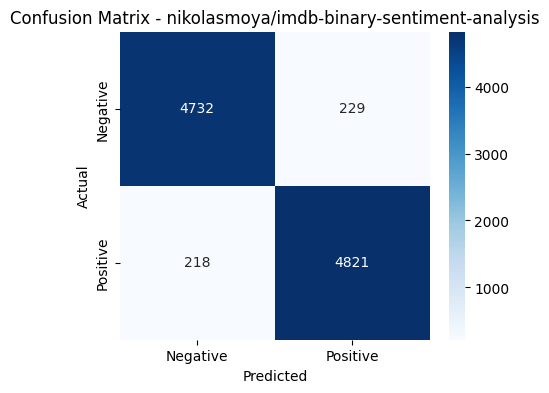

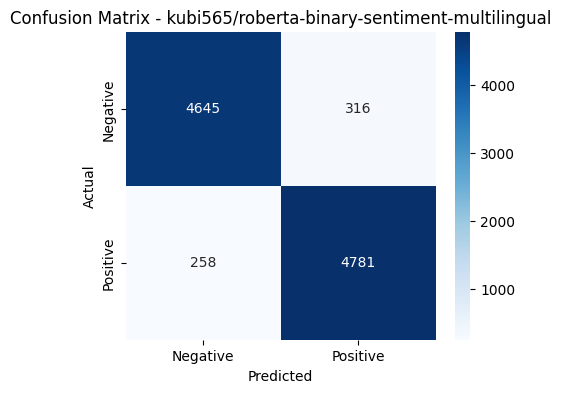

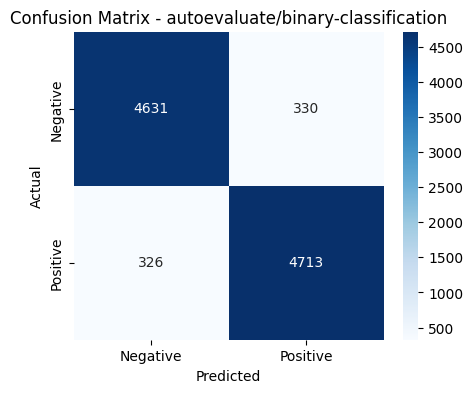

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix visualization
def plot_conf_matrix(true, pred, model_name):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_conf_matrix(test_labels, nikolasmoya_preds, "nikolasmoya/imdb-binary-sentiment-analysis")
plot_conf_matrix(test_labels, roberta_preds, "kubi565/roberta-binary-sentiment-multilingual")
plot_conf_matrix(test_labels, binary_classification_preds, "autoevaluate/binary-classification")